In [2]:
import os 
import tarfile
import pyprind
import pandas as pd
from packaging import version
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import re
from wordcloud import WordCloud

from sklearn.model_selection import learning_curve

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Load the dataset
df = pd.read_csv('movie_data.csv')
print(df.count())


review       50000
sentiment    50000
dtype: int64


In [5]:
# Define preprocessing functions
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # POS tagging
    pos_tags = pos_tag(tokens)
    
    # Lemmatization and Stemming
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    processed_tokens = []
    for word, tag in pos_tags:
        lemmatized_word = lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        stemmed_word = stemmer.stem(lemmatized_word)
        processed_tokens.append(stemmed_word)
    
    return ' '.join(processed_tokens)

In [6]:
# Apply preprocessing to the reviews
df['processed_review'] = df['review'].apply(preprocess_text)

In [7]:
# Split the data into training and test sets
X = df['processed_review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Create a pipeline with TfidfVectorizer and LinearSVC
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('clf', LinearSVC())
])

In [9]:
# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)


c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [10]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy}')

# Generate and print the classification report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print(report)

Test accuracy: 0.8896
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.89      4976
    Positive       0.89      0.90      0.89      5024

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



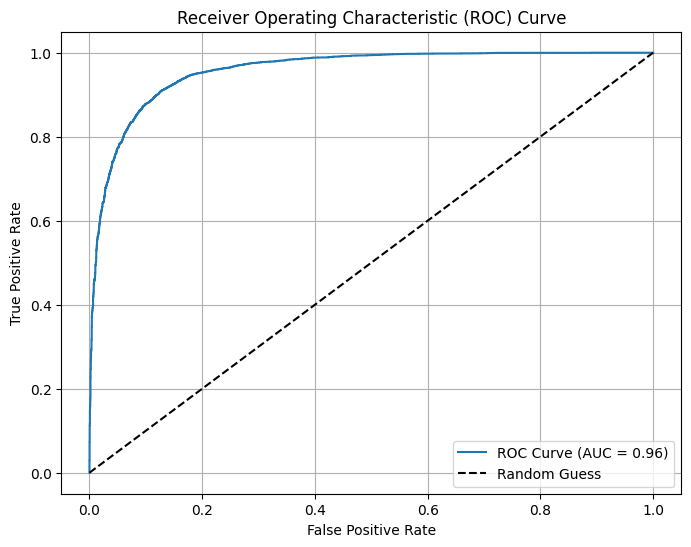

In [11]:
# Compute the ROC curve and AUC score
y_scores = pipeline.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc_score = roc_auc_score(y_test, y_scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [12]:
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))


In [13]:
# Compute the mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

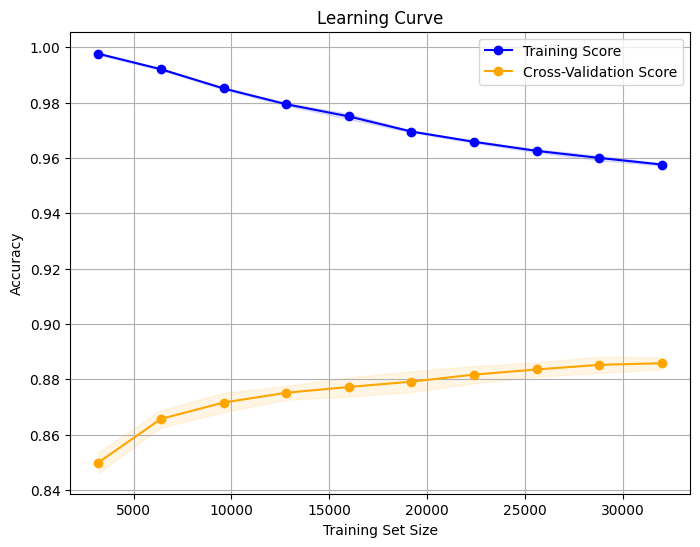

In [14]:
# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Cross-Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

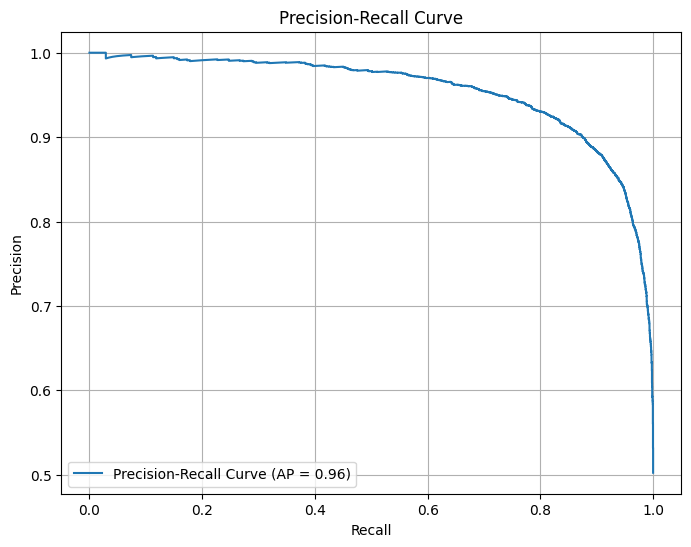

In [15]:
# Compute the precision-recall curve and average precision score
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

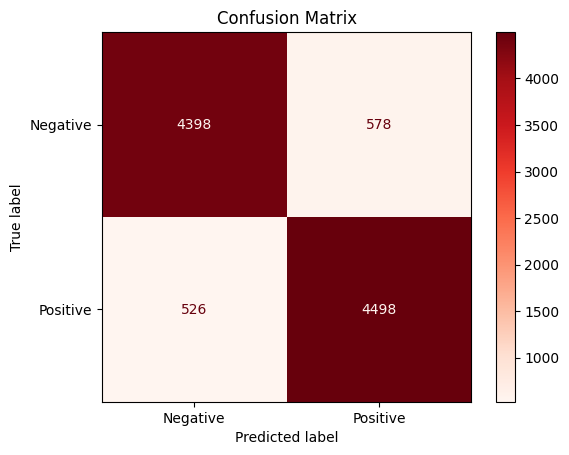

In [16]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Function to predict sentiment of a given text
def predict_sentiment(text, pipeline):
    processed_text = preprocess_text(text)
    pred = pipeline.predict([processed_text])
    return 'Positive' if pred[0] == 1 else 'Negative'

In [18]:
# Example sentences
examples = [
    "The movie was a waste of time, it had no interesting scenes.",
    "An amazing experience! The storyline was captivating from start to finish.",
    "It was a decent film, but it lacked depth in some parts.",
    "The performances were mediocre, and the plot was predictable.",
    "I thoroughly enjoyed the film, the acting and direction were top-notch.",
    "The script was poorly written and the dialogue was cringe-worthy.",
    "A delightful surprise! The movie exceeded all my expectations.",
    "Not worth the hype. It was just another generic action movie.",
    "A heartwarming story that left me in tears. Absolutely beautiful.",
    "The special effects were stunning, but the storyline was lacking."
]

In [19]:
# Display predictions
for sentence in examples:
    sentiment = predict_sentiment(sentence, pipeline)
    print(f"Review: {sentence}\nPredicted Sentiment: {sentiment}\n")


Review: The movie was a waste of time, it had no interesting scenes.
Predicted Sentiment: Negative

Review: An amazing experience! The storyline was captivating from start to finish.
Predicted Sentiment: Positive

Review: It was a decent film, but it lacked depth in some parts.
Predicted Sentiment: Negative

Review: The performances were mediocre, and the plot was predictable.
Predicted Sentiment: Negative

Review: I thoroughly enjoyed the film, the acting and direction were top-notch.
Predicted Sentiment: Positive

Review: The script was poorly written and the dialogue was cringe-worthy.
Predicted Sentiment: Negative

Review: A delightful surprise! The movie exceeded all my expectations.
Predicted Sentiment: Positive

Review: Not worth the hype. It was just another generic action movie.
Predicted Sentiment: Negative

Review: A heartwarming story that left me in tears. Absolutely beautiful.
Predicted Sentiment: Positive

Review: The special effects were stunning, but the storyline was 

In [20]:
# Generate and display word clouds
all_text = re.sub(r'<br\s*/?>', '', ' '.join(df['review']))
positive_text = re.sub(r'<br\s*/?>', '', ' '.join(df[df['sentiment'] == 1]['review']))
negative_text = re.sub(r'<br\s*/?>', '', ' '.join(df[df['sentiment'] == 0]['review']))

wordcloud_all = WordCloud(width=900, height=500, background_color='black').generate(all_text)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)


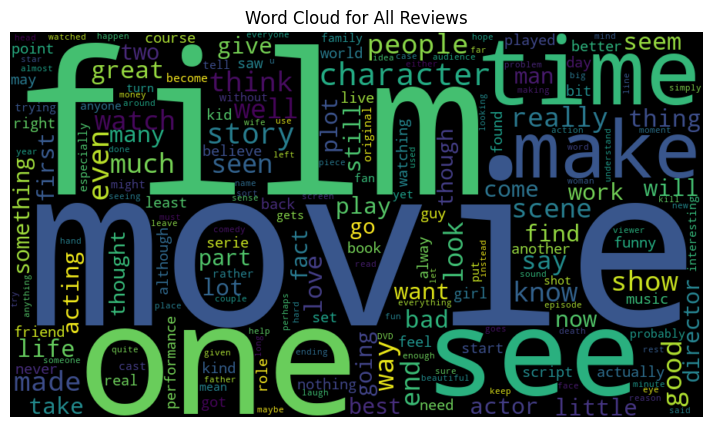

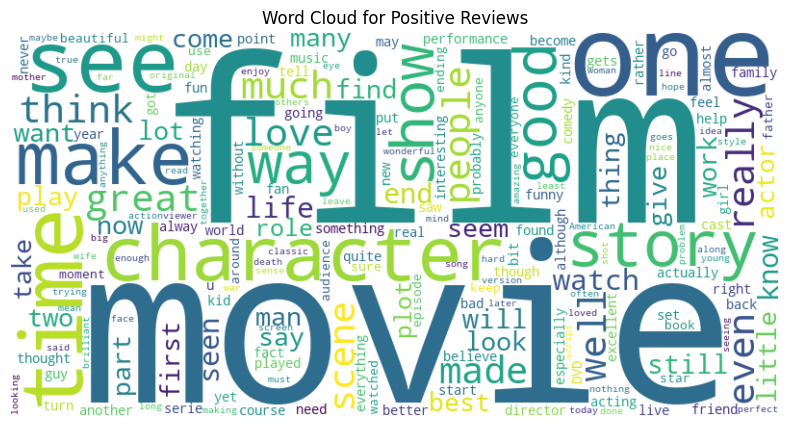

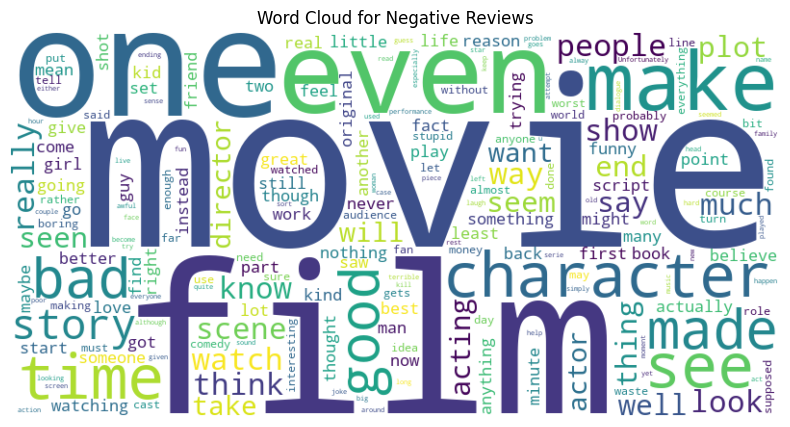

In [21]:
# Display the word clouds
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.title('Word Cloud for All Reviews')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

In [22]:
examples2 = [
    df["review"][65],
    df["review"][1000],
    df["review"][548],
    df["review"][600],
    df["review"][400]
]

for sentence in examples2:
    sentiment = predict_sentiment(sentence, pipeline)
    print(f"Review: {sentence}\nPrediction:{sentiment}\n")
    


Review: The monster will look very familiar to you. So will the rest of the film, if you've seen a half-dozen of these teenagers-trapped-in-the-woods movies. Okay, so they're not teenagers, this time, but they may as well be. Three couples decide it might be a good idea to check out a nearly-abandoned ghost town, in hopes of finding the gold that people were killed over a scant century-and-a-half before. You'd think that with a title like "Miner's Massacre" some interesting things might happen. They don't. In fact, only about 1/10 of the film actually takes place in the mine. I had envisioned teams of terrified miners scampering for their lives in the cavernous confines of their workplace, praying that Black Lung Disease would get them before The Grim Reaper exacted his grisly revenge, but instead I got terrestrial twenty-somethings fornicating--and, in one case, defecating--in the woods, a gang of morons with a collective I.Q. that would have difficulty pulling a plastic ring out of a

In [30]:
#df["sentiment"][65]
#df["sentiment"][1000]
#df["sentiment"][548]
#df["sentiment"][600]
df["sentiment"][400]


1